In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import python_speech_features
from scipy.io import wavfile
%matplotlib notebook
from hmmlearn import hmm

ModuleNotFoundError: No module named 'python_speech_features'

In [48]:
fold_path = "/home/thangnd/git/python_workspace/data/audio/"
fpaths = []
labels = []
spoken = []
for f in os.listdir(fold_path):
    for w in os.listdir(fold_path + f):
        fpaths.append(fold_path + f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print('Words spoken:', spoken)

Words spoken: ['orange', 'pineapple', 'banana', 'apple', 'peach', 'lime', 'kiwi']


In [49]:
#Files can be heard in Linux using the following commands from the command line
#cat kiwi07.wav | aplay -f S16_LE -t wav -r 8000
#Files are signed 16 bit raw, sample rate 8000
data = np.zeros((len(fpaths), 32000))
maxsize = -1
for n,file in enumerate(fpaths):
    _, d = wavfile.read(file)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize]

#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', data.shape[0])
all_labels = np.zeros(data.shape[0])
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
    
print('Labels and label indices', all_labels)

Number of files total: 105
Labels and label indices [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [50]:
import scipy

def stft(x, fftsize=64, overlap_pct=.5):   
    #Modified from http://stackoverflow.com/questions/2459295/stft-and-istft-in-python
    hop = int(fftsize * (1 - overlap_pct))
    w = scipy.hanning(fftsize + 1)[:-1]    
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

(216, 32)


<IPython.core.display.Javascript object>


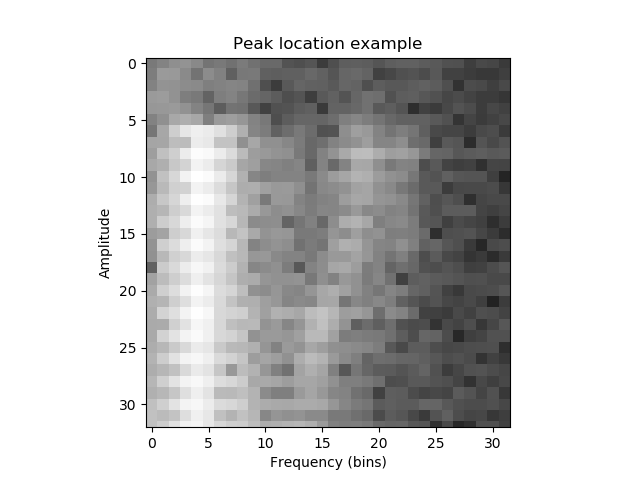

Text(0.5,1,'PSD of orange example')

In [51]:
import matplotlib.pyplot as plt

# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data[0, :])) + 1)


print(log_freq.shape)
plt.imshow(log_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])

In [34]:
log_freq.shape

(216, 32)

In [52]:
from numpy.lib.stride_tricks import as_strided

#Peak detection using the technique described here: http://kkjkok.blogspot.com/2013/12/dsp-snippets_9.html 
def peakfind(x, n_peaks, l_size=3, r_size=3, c_size=3, f=np.mean):
    win_size = l_size + r_size + c_size
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
    r = np.apply_along_axis(is_peak, 1, xs)
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]

In [53]:
plot_data = np.abs(stft(data[20, :]))[15, :]
values, locs = peakfind(plot_data, n_peaks=6)
fp = locs[values > -1]
fv = values[values > -1]
plt.plot(plot_data, color='steelblue')
plt.plot(fp, fv, 'x', color='darkred')
plt.title('Peak location example')
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')

Text(113.015,0.5,'Amplitude')

In [54]:
#This processing (top freq peaks) only works for single speaker case... need better features for multispeaker!
#MFCC (or deep NN/automatic feature extraction) could be interesting
all_obs = []
for i in range(data.shape[0]):
    d = np.abs(stft(data[i, :]))
    n_dim = 6
    obs = np.zeros((n_dim, d.shape[0]))
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks=n_dim)
        obs[:, r] = t.copy()
    if i % 10 == 0:
        print("Processed obs %s" % i)
    all_obs.append(obs)
    
all_obs = np.atleast_3d(all_obs)

Processed obs 0
Processed obs 10
Processed obs 20
Processed obs 30
Processed obs 40
Processed obs 50
Processed obs 60
Processed obs 70
Processed obs 80
Processed obs 90
Processed obs 100


In [36]:
d = np.abs(stft(data[2, :]))

In [58]:
from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(all_labels, test_size=0.1, random_state=0)



for n,i in enumerate(all_obs):
    all_obs[n] /= all_obs[n].sum(axis=0)

    
    
    
for train_index, test_index in sss:
    X_train, X_test = all_obs[train_index, ...], all_obs[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]

    
    
print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

Size of training matrix: (94, 6, 216)
Size of testing matrix: (11, 6, 216)


/home/thangnd/python_env/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [64]:
X_test.shape

(11, 6, 216)

In [66]:
from hmmlearn import hmm

ys = set(all_labels)
ms = [hmm.GaussianHMM(n_components=6) for y in ys]
for m, y in zip(ms, ys):
    temp = X_train[y_train == y, :, :]
    m.fit(temp.reshape(-1, 216), [6 for i in range(temp.shape[0])])

ps = [m.predict(X_test.reshape(-1, 216), [6 for i in range(11)]) for m in ms]

res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
missed = (predicted_labels != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

Test accuracy: 0.00 percent


/home/thangnd/python_env/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  del sys.path[0]


Text(0.5,0,'Predicted label')

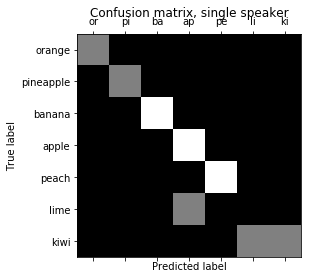

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:2] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
plt.title('Confusion matrix, single speaker')
plt.ylabel('True label')
plt.xlabel('Predicted label')